In [1]:
# libraries for querying astro images and processing them
from astroquery.alma import Alma
from astroquery.skyview import SkyView
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astropy.modeling import models, fitting
from astropy.convolution import convolve, interpolate_replace_nans
from astropy.convolution import Gaussian2DKernel
from astropy.stats import sigma_clip, sigma_clipped_stats
import os
import skimage
from skimage.filters import *
import numpy as np
from skimage import io, exposure, morphology, filters, feature
from skimage.feature import blob_dog, blob_log, blob_doh
import cv2
from math import sqrt
import scipy.optimize as opt
import statmorph
import photutils
import scipy.ndimage as ndi
import pandas as pd
from scipy import ndimage

# plotting libraries
from matplotlib import pylab
import pylab as py
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

# libraries for machine learning
from sklearn import decomposition
from sklearn import preprocessing


# random libraries
import time
import math
import warnings
import pickle

import multiprocessing as mp

plt.style.use(astropy_mpl_style)
sns.reset_orig()

In [ ]:
import os

directory = 'processed_images_pickle'

processed_galaxies = {}

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        with open(f, 'rb') as file:
            img = pickle.load(file)
            gal = filename.replace('.pickle', '')
            processed_galaxies[gal] = img

In [ ]:
# data augmentation

import albumentations as A
import copy

transform = A.Compose([A.HorizontalFlip(p=0.7),
                       A.VerticalFlip(p=0.7),
                      ]
)

full_data = {}
residual_full_data = {}

i = 0


# sersic_fits[galaxy] = [original_img_data, image_model, theta, rhalfellip, rmaj, rhalf_circ, r20, r50, r80, 
                        # rmax_circ, rmax_ellip, rpetro_circ, rpetro_ellip, ellip, rmin, sersic_xc, 
                        # sersic_yc, cent_xc, cent_yc, best_cent, residual, processed_img, processed_residual]

for galaxy, model in processed_galaxies.items():
    img = model[-2]
    transformed_img = transform(image=img)['image']
    full_data[galaxy] = img
    name = galaxy + '_xyflipped'
    full_data[name] = transformed_img
    print(i, end='\r')
    
    res = model[-1]
    residual_full_data[galaxy + '_res'] = res
    transformed_res = transform(image=res)['image']
    residual_full_data[galaxy + '_xyflipped_res'] = transformed_res
    
    i += 1

In [136]:
with open('full_data.pickle', 'rb') as f:
    full_data = pickle.load(f)

In [137]:
## code for flattening and conducting PCA on images


# create data matrix

data_list = []
error_data_list = []

# sersic_fits[galaxy] = [original_img_data, image_model, theta, rhalfellip, rmaj, rhalf_circ, r20, r50, r80, 
                      # rmax_circ, rmax_ellip, rpetro_circ, rpetro_ellip, ellip, rmin, residual, 
                      # processed_image, processed_residual]

i = 0
        
for galaxy, item in full_data.items():
    try:
        
        #         preprocess and scale each image's pixel values
        img = item
        scale_factor = 1/(img.max()-img.min())
        img_scaled = (img-img.min())*scale_factor
        img_scaled -= img_scaled.mean() # center data
        

#         transformer = preprocessing.MinMaxScaler(feature_range=(1, 2)).fit(img)
#         img_scaled = transformer.transform(img)
# #         img_scaled = np.log(img_scaled)

#         img_min = img.min()
    
#         if img_min < 0:
#             img_scaled = img - img_min
#         else:
#             img_scaled = img
                                                                                              
        data_row = img_scaled.flatten()
        data_list.append(data_row)
        
    except:
        error_data_list.append(galaxy)
        
    print(i, end='\r')
    i += 1
    
data_matrix = np.vstack(data_list)


In [179]:
# conduct PCA

NO_COMPONENTS = 21

pca = decomposition.PCA(n_components=NO_COMPONENTS)
pca.fit(data_matrix)

pca_matrix = pca.components_[:NO_COMPONENTS]



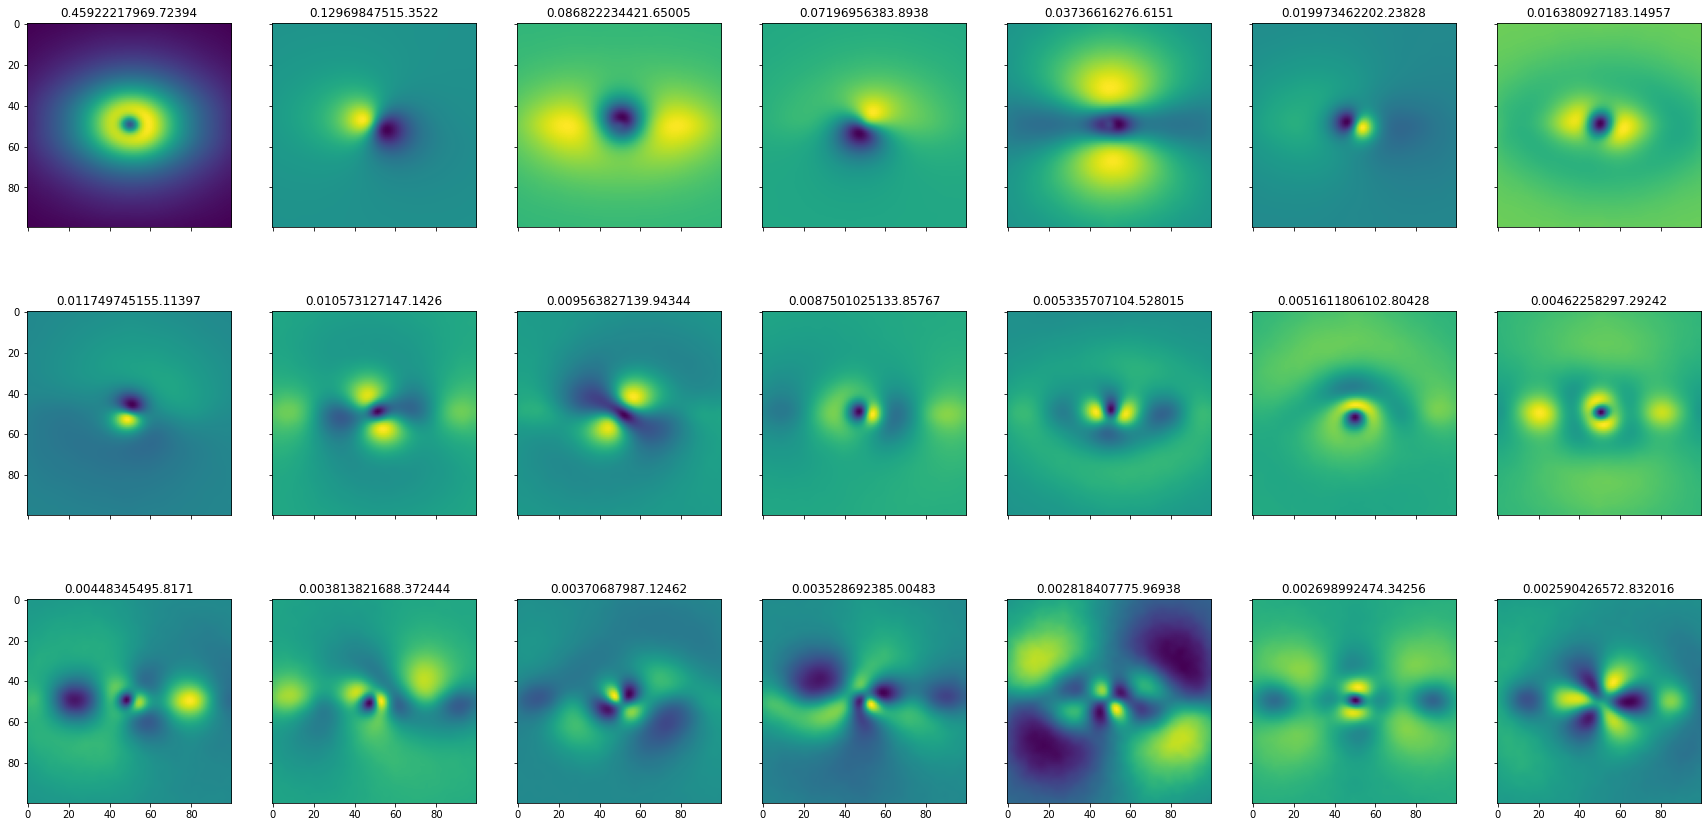

In [181]:
# plot PCA components
fig, axes = plt.subplots(3, 7, figsize=(30, 15), sharex=True, sharey=True)
ax = axes.ravel()

i = 0

for row, var, val in zip(pca_matrix, pca.explained_variance_ratio_, pca.singular_values_):
    
    component = row.reshape([100, 100])
    ax[i].set_title(str(var) + str(val))
    ax[i].imshow(component, )

    print(i, end='\r')
    i += 1
    if i == 21:
        break


90.0829829275608


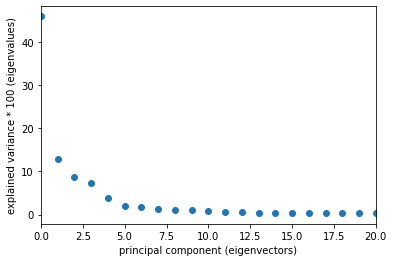

In [178]:
# reconstruct original images from components

y = (pca.explained_variance_ratio_*100).tolist()
x = list(range(0, len(y)))

print(sum(y[:21]))
plt.xlabel('principal component (eigenvectors)')
plt.ylabel('explained variance * 100 (eigenvalues)')
plt.xlim(0, 20)
plt.scatter(x, y)

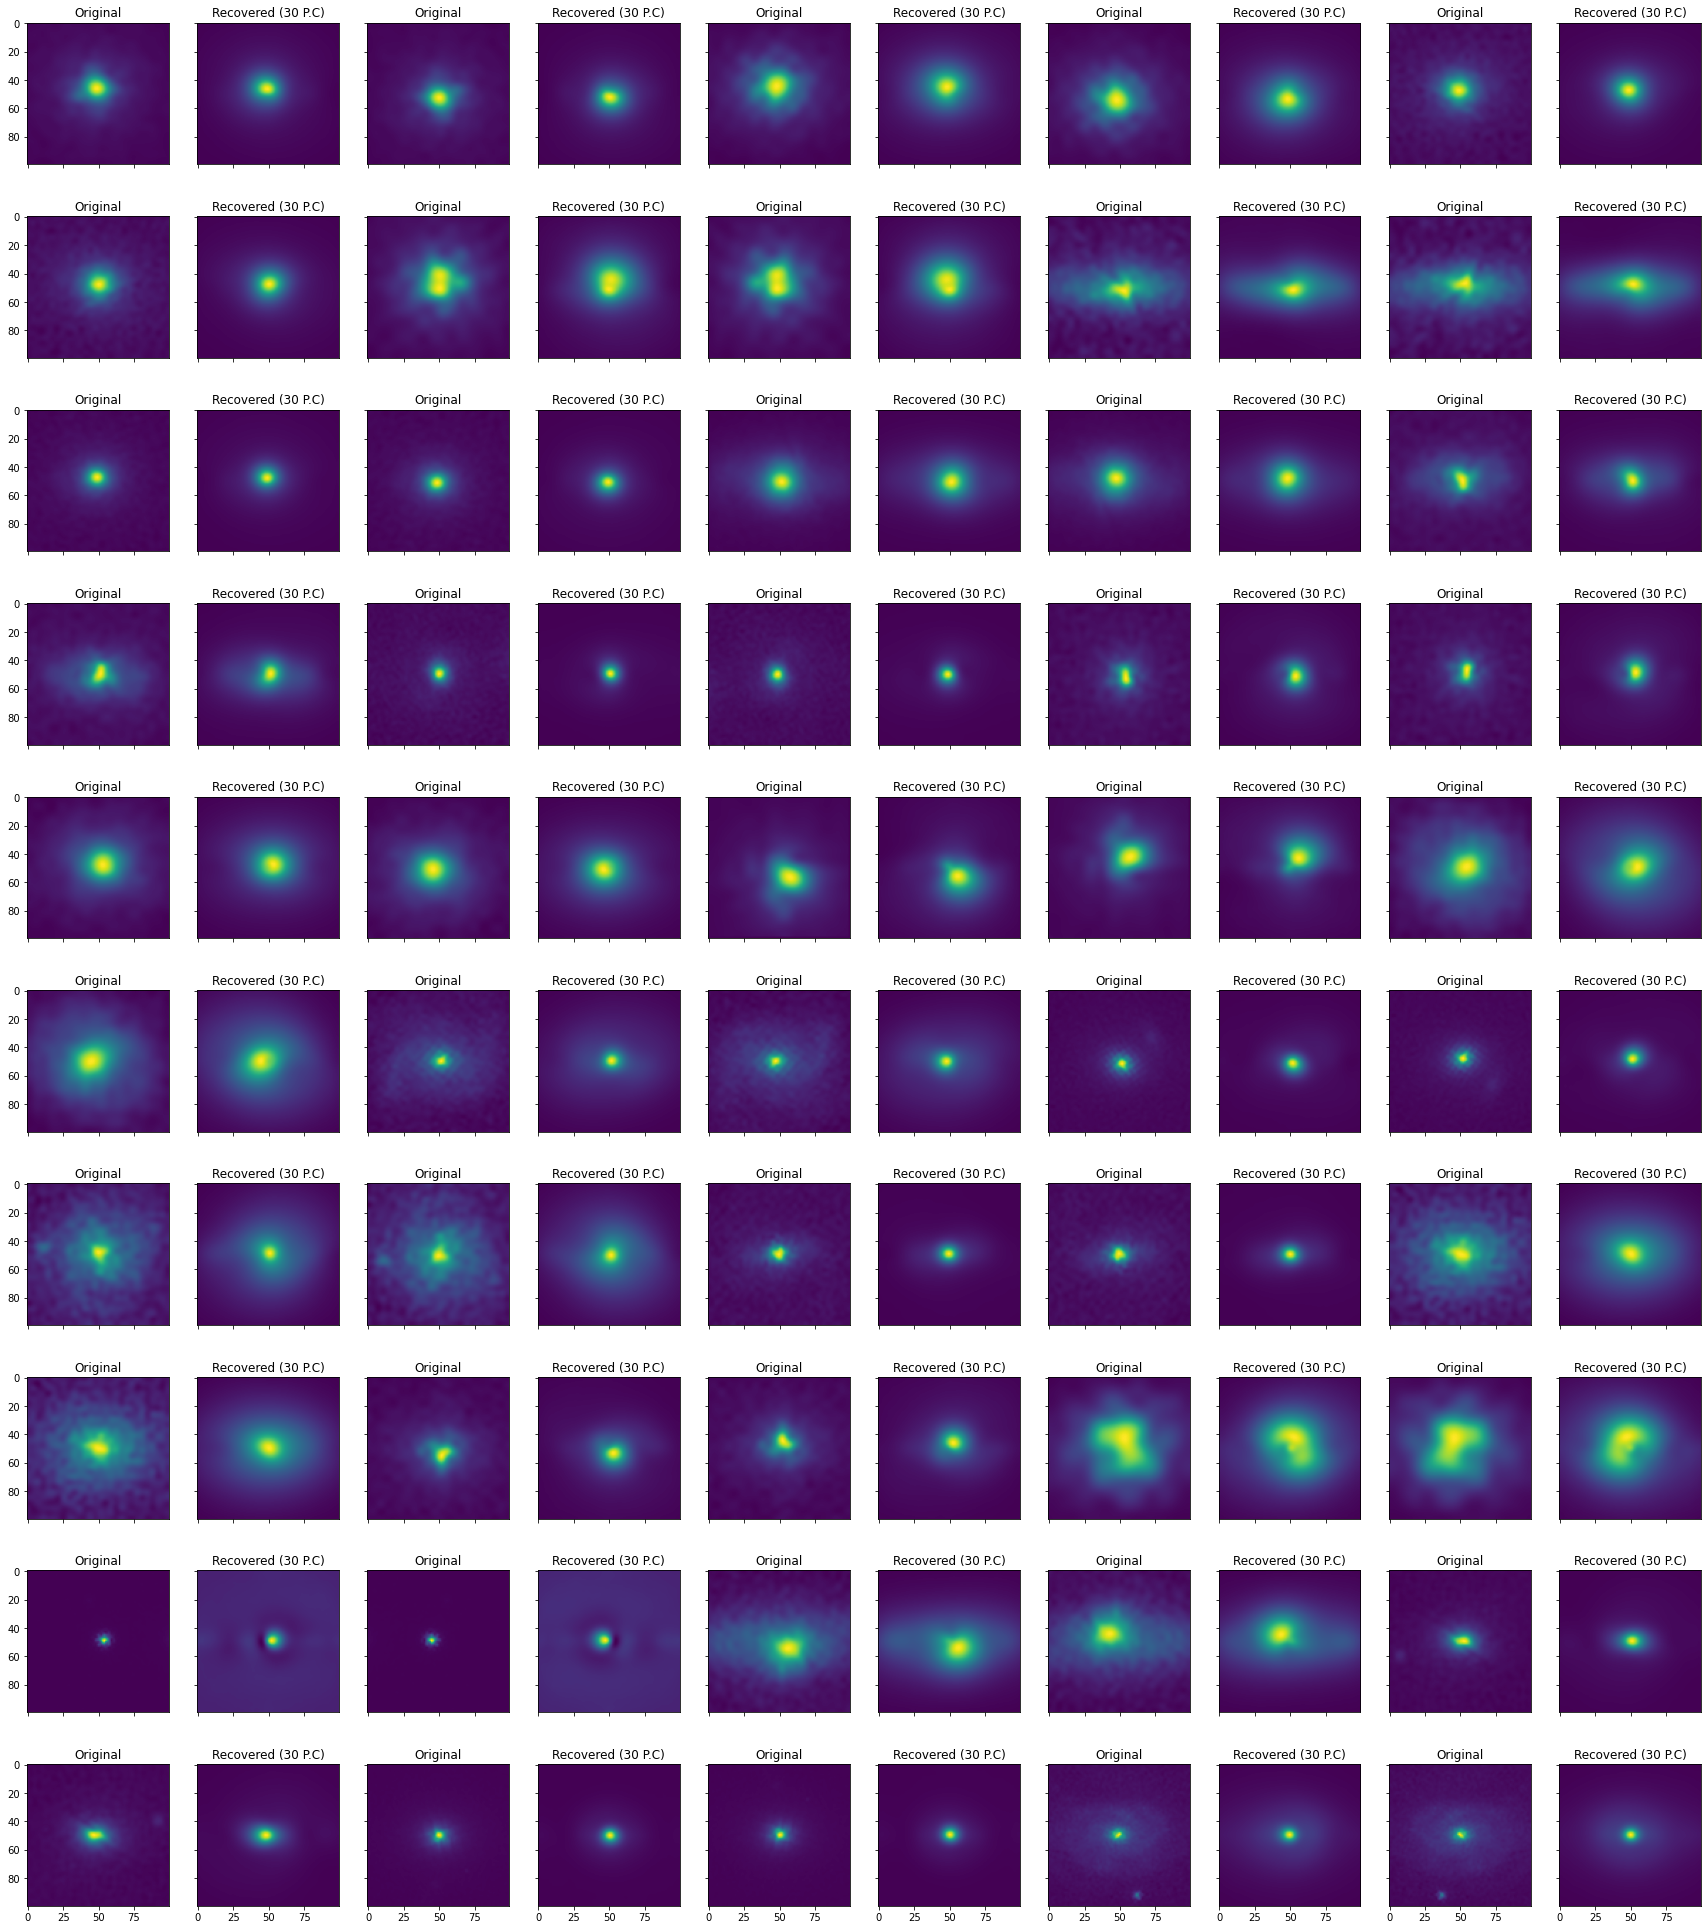

In [183]:
fig, axes = plt.subplots(10, 10, figsize=(30, 35), sharex=True, sharey=True)
ax = axes.ravel()


trans = pca.transform(data_matrix)

inv = pca.inverse_transform(trans)

i = 0
j = 0

while j < 50:
    ax[i].imshow(data_matrix[j].reshape((100,100)))
    ax[i].set_title('Original')
    ax[i+1].imshow(inv[j].reshape([100, 100]))
    ax[i+1].set_title('Recovered (30 P.C)')
    j += 1
    i += 2



[0.0001261567, 0.00014038486, 0.0002065521, 0.0002081172, 8.073263e-05, 7.968344e-05, 0.0004925467, 0.00049996446, 0.0003948075, 0.00039891363, 3.0522715e-05, 3.5422076e-05, 2.6193056e-05, 2.8331777e-05, 0.00017581132, 0.00017302479, 6.183961e-05, 6.60383e-05, 0.00028200622, 0.00028145226, 8.516828e-05, 8.9290406e-05, 0.00036663943, 0.00039245878, 0.00014890239, 0.00015232446, 0.00019194873, 0.00019662779, 9.1241556e-05, 0.00010269281, 0.00072549784, 0.0007377774, 0.000118308904, 0.00012038809, 0.00054847565, 0.00054847565, 0.00028310146, 0.00027651296, 0.0006641164, 0.0007110275, 0.00032505428, 0.00033627887, 0.00026089486, 0.00026594344, 0.00012445525, 0.00013088417, 5.3869586e-05, 5.2623778e-05, 0.00022691138, 0.00021731076]


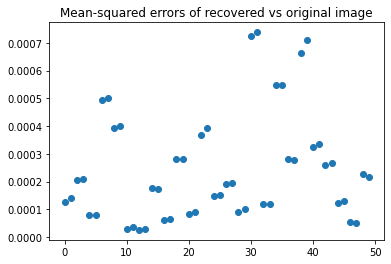

In [195]:
mse_list = []

for i in range(50):
    mse = ((data_matrix[i].reshape((100,100)) - inv[i].reshape((100,100)))**2).mean(axis=None)
    mse_list.append(mse)
    



plt.scatter(list(range(50)), mse_list)
plt.title('Mean-squared errors of recovered vs original image')
plt.show()

In [128]:
# conduct SVD

# delete full_data to free up ram

print('start')
full_data = 0

NO_COMPONENTS = data_matrix.shape[0]
 
svd = decomposition.TruncatedSVD(n_components=100,)
svd.fit(data_matrix[:1000])

svd_matrix = svd.components_[:NO_COMPONENTS]

start


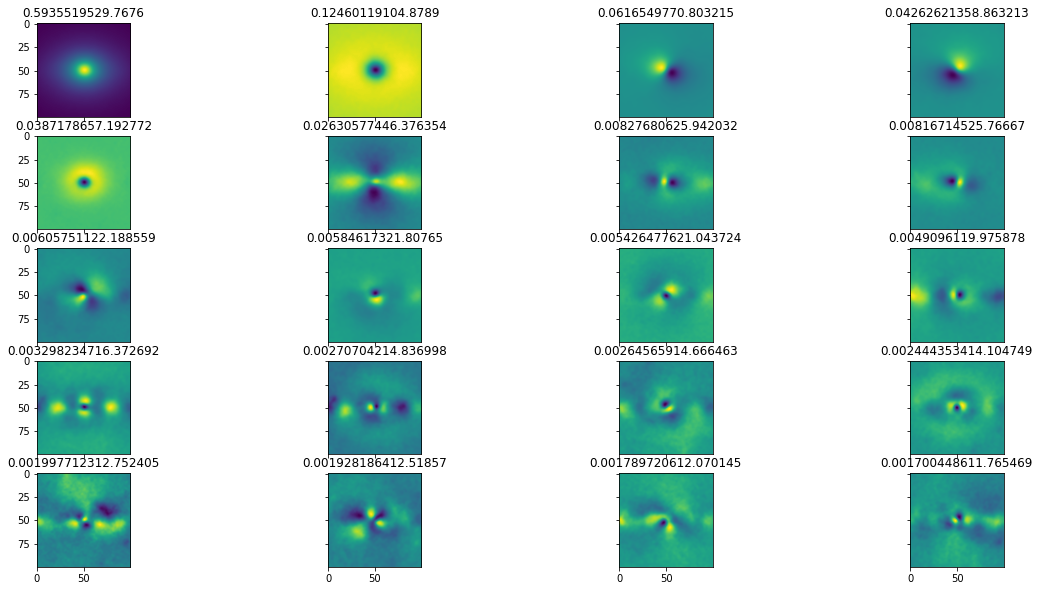

In [132]:
# plot SVD components
fig, axes = plt.subplots(5, 4, figsize=(20, 10), sharex=True, sharey=True)
ax = axes.ravel()

i = 0

for row, var, val in zip(svd_matrix, svd.explained_variance_ratio_, svd.singular_values_):
    
    component = row.reshape([100, 100])
    ax[i].set_title(str(var) + str(val))
    ax[i].imshow(component, )

    print(i, end='\r')
    i += 1
    if i == 20:
        break

92.6141594350338


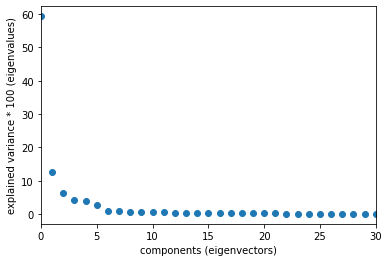

In [130]:
# reconstruct original images from components


ysvd = (svd.explained_variance_ratio_*100).tolist()
xsvd = list(range(0, len(ysvd)))

print(sum(ysvd[:12]))

plt.xlabel('components (eigenvectors)')
plt.ylabel('explained variance * 100 (eigenvalues)')
plt.xlim(0, 30)
plt.scatter(xsvd, ysvd)